CLASSIFICATION BINARIZED FOR EACH CLASS.

In [26]:
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve,auc, average_precision_score, f1_score,accuracy_score,log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging
import pandas as pd
from typing import Tuple 
from torch import nn
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import wordnet as wn
import random
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from typing import List, Set
from torch import cuda
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
import ast


# ----------------------------------------------------------------------------------------------------------
## CREATION OF EMBBEDINGS
# ----------------------------------------------------------------------------------------------------------


In [ ]:
ROUTE_BINARIZED_NAICS= '../src/data/DF_NAICS_BINARIZED_BUENO_2.csv'
df_naics = pd.read_csv(ROUTE_BINARIZED_NAICS) 
print(df_naics.head())
count_of_ones = df_naics.apply(lambda x: (x == 1).sum())


print(count_of_ones)



import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Descargar recursos de NLTK necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    """Convertir el tag de POS de treebank a wordnet tag"""
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def preprocess_text(text):
    # Tokenizar utilizando NLTK, manteniendo el caso original para el POS tagging
    tokens = word_tokenize(text)
    # POS tagging
    tagged_tokens = pos_tag(tokens)
    # Procesamiento basado en POS
    processed_tokens = []
    for word, tag in tagged_tokens:
        # Aplicar lematización solo si no es un nombre propio o un símbolo
        if not tag.startswith('NNP') and not tag.startswith('NNPS') and word.isalnum():
            wordnet_pos = get_wordnet_pos(tag)  # Obtener el POS compatible con WordNet
            if wordnet_pos:
                word = lemmatizer.lemmatize(word, pos=wordnet_pos)
            else:
                word = lemmatizer.lemmatize(word)
            word = word.lower()  # Convertir a minúsculas después de lematizar
        # Filtrar stopwords y nombres propios, mantener los nombres propios si necesarios
        if word.lower() not in stop_words and word.isalnum():
            processed_tokens.append(word)
    return processed_tokens

def preprocess_dataframe(df, column_name):
    # Aplicar la función de preprocesamiento al DataFrame
    df[column_name] = df[column_name].apply(preprocess_text)
    return df



df_naics_preprocessed = preprocess_dataframe(df_naics, 'BUSINESS_DESCRIPTION')
print(df_naics_preprocessed.head())

count_of_ones = df_naics_preprocessed.apply(lambda x: (x == 1).sum())


print(count_of_ones)



from transformers import DistilBertModel, DistilBertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.texts = dataframe['BUSINESS_DESCRIPTION'].astype(str).tolist()
        self.max_len = max_len
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Congelar todos los pesos excepto los de la última capa transformer
        for name, param in self.model.named_parameters():
            if 'transformer.layer.5' not in name:  # Asumiendo que la última capa es la número 5
                param.requires_grad = False

        self.naics_columns = dataframe.columns[1:].tolist()
        self.labels = dataframe[self.naics_columns].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        outputs = self.model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Obtener solo el primer token (CLS token)

        label = self.labels[idx]  # Los labels ya son un array binario para cada fila

        return {
            'embeddings': embeddings.squeeze().detach().cpu().numpy(),
            'labels': label
        }

def create_dataframe(dataset):
    data = []
    for i in range(len(dataset)):
        item = dataset[i]
        row = {'embeddings': item['embeddings']}
        row.update({naics: int(label) for naics, label in zip(dataset.naics_columns, item['labels'])})
        data.append(row)
    df_embeddings = pd.DataFrame(data)
    df_embeddings['embeddings'] = df_embeddings['embeddings'].apply(lambda x: list(x))
    return df_embeddings

dataset = CustomDataset(dataframe=df_naics_preprocessed, max_len=128)
df_embeddings_naics = create_dataframe(dataset)
print(df_embeddings_naics.head())



count_of_ones = df_embeddings_naics.apply(lambda x: (x == 1).sum())


print(count_of_ones)

# ----------------------------------------------------------------------------------------------------------
## LOADING DF EMBBEDINGS AND STARTING WITH MODELS
# ----------------------------------------------------------------------------------------------------------

In [31]:
ROUTE_BINARIZED_NAICS= '../src/data/BUENO_POR_FIN_2.csv'
df_naics = pd.read_csv(ROUTE_BINARIZED_NAICS) 
print(df_naics.head())
count_of_ones = df_naics.apply(lambda x: (x == 1).sum())
print(count_of_ones)

   Unnamed: 0                                         embeddings  11  21  22  \
0           0  [0.3421159, 0.24559289, 0.003188484, -0.454343...   1   0   1   
1           1  [0.37763986, 0.31703675, 0.2015006, -0.1750039...   0   0   0   
2           2  [0.3418419, 0.19359905, 0.4428423, -0.11424164...   0   0   0   
3           3  [0.19853792, 0.14060616, 0.31806898, -0.309403...   0   0   0   
4           4  [0.36185867, 0.218326, 0.29591516, -0.23454015...   0   0   0   

   23  31  32  33  42  ...  53  54  55  56  61  62  71  72  81  92  
0   1   0   1   0   0  ...   0   0   0   1   0   0   0   0   0   0  
1   1   0   1   1   1  ...   0   0   0   0   0   0   0   0   0   0  
2   1   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   1   0   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
4   1   0   0   1   1  ...   1   1   0   1   0   1   0   0   1   0  

[5 rows x 26 columns]
Unnamed: 0        1
embeddings        0
11             1162
21              706
22

## balancear clases

In [28]:
def selectively_reduce_rows(df, threshold=1250, reduction_rate=0.75):
    
    class_counts = df.iloc[:, 2:].apply(pd.value_counts).loc[1]
    classes_to_reduce = class_counts[class_counts > threshold].index.tolist()
    keep_prob = 1 - reduction_rate

    for class_col in classes_to_reduce:
        mask = (df[class_col] == 1)
        random_selection = np.random.rand(mask.sum()) > keep_prob 
        df.loc[mask, class_col] = np.where(random_selection, 0, 1)  

    return df

df_reduced = selectively_reduce_rows(df_naics, threshold=1250, reduction_rate=0.5)
print(df_reduced.head())
count_of_ones = df_naics.apply(lambda x: (x == 1).sum())
print(count_of_ones)

   Unnamed: 0                                         embeddings  11  21  22  \
0           0  [0.3421159, 0.24559289, 0.003188484, -0.454343...   1   0   1   
1           1  [0.37763986, 0.31703675, 0.2015006, -0.1750039...   0   0   0   
2           2  [0.3418419, 0.19359905, 0.4428423, -0.11424164...   0   0   0   
3           3  [0.19853792, 0.14060616, 0.31806898, -0.309403...   0   0   0   
4           4  [0.36185867, 0.218326, 0.29591516, -0.23454015...   0   0   0   

   23  31  32  33  42  ...  53  54  55  56  61  62  71  72  81  92  
0   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
2   0   0   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   1   0   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
4   0   0   0   0   0  ...   0   1   0   1   0   1   0   0   0   0  

[5 rows x 26 columns]
Unnamed: 0       1
embeddings       0
11            1162
21             706
22    

/tmp/ipykernel_18143/2643425263.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_counts = df.iloc[:, 2:].apply(pd.value_counts).loc[1]


/tmp/ipykernel_18143/596625109.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = df_naics[class_columns].apply(pd.value_counts).loc[1].sort_values()


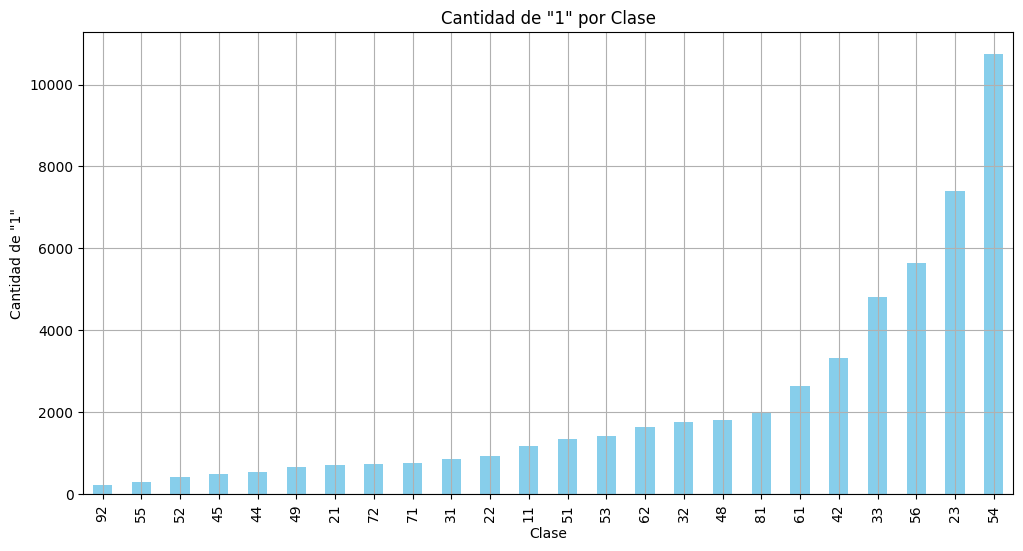

La clase en la posición media del ranking es: 51


In [32]:
class_columns = df_naics.columns[2:]
counts = df_naics[class_columns].apply(pd.value_counts).loc[1].sort_values()

middle_class = counts.index[len(counts) // 2]  


plt.figure(figsize=(12, 6))
counts.sort_values().plot(kind='bar', color='skyblue')
plt.title('Cantidad de "1" por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de "1"')
plt.grid(True)
plt.show()

print(f"La clase en la posición media del ranking es: {middle_class}")


In [55]:
results = {col: {'unique_ones': 0, 'non_unique_ones': 0} for col in class_columns}

class_columns = df_naics.columns[1:]  # ajusta esto a tus columnas de clase reales

# Calculamos el total de '1' para cada clase
total_ones_per_class = df_naics[class_columns].sum()

def adjust_row(row):
    if row.sum() > 1:  # Chequeamos si la fila tiene más de un '1'
        # Encuentra las clases activas en esta fila
        active_classes = row[row == 1].index
        
        # Encuentra la clase con el menor total de '1' entre las activas
        least_represented_class = total_ones_per_class[active_classes].idxmin()
        
        # Desactiva todos los '1' excepto en la clase menos representada
        row[:] = 0
        row[least_represented_class] = 1
    return row

# Aplicar la función de ajuste a cada fila
df_naics[class_columns] = df_naics[class_columns].apply(adjust_row, axis=1)


# Iterar sobre cada fila y actualizar los conteos
for index, row in df_naics.iterrows():
    # Contar el número total de '1' en las columnas de clase
    total_ones = row[class_columns].sum()
    
    # Identificar si cada '1' es único o no
    for col in class_columns:
        if row[col] == 1:
            if total_ones == 1:
                results[col]['unique_ones'] += 1
            else:
                results[col]['non_unique_ones'] += 1

# Imprimir los resultados
for class_name, counts in results.items():
    print(f"Clase {class_name}:")
    print(f"  '1' únicos: {counts['unique_ones']}")
    print(f"  '1' no únicos: {counts['non_unique_ones']}\n")

In [33]:
df_naics['embeddings'] = df_naics['embeddings'].apply(ast.literal_eval)

## WITH MORE BALANCED CLASSES, MODELS:

F1 Score: 0.34688346883468835
Matriz de Confusión:
[[5626  238]
 [   3   64]]
AUC de la Curva de Precisión-Recall: 0.86


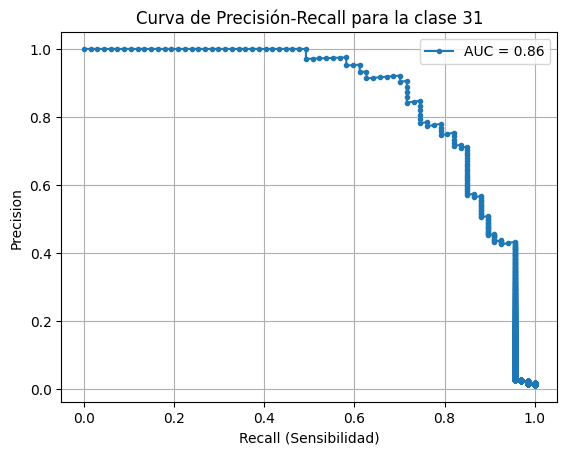

In [54]:

# Convertir lista de listas a un array de NumPy para X
X = np.array(df_naics['embeddings'].tolist())
y = df_naics['55']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo de regresión logística con balanceo de clase
model = LogisticRegression(class_weight='balanced',C=0.25, max_iter=1000)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]  # probabilidades para la clase positiva

# Calcular el F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva de Precisión-Recall y AUC
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_score = auc(recall, precision)
print(f'AUC de la Curva de Precisión-Recall: {auc_score:.2f}')

plt.figure()
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score:.2f}')
plt.title('Curva de Precisión-Recall para la clase 31')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()